# Notebook to visualize blurred images

Subtype: amyloid_plaque_patches | total patches: 19 | showing: 3


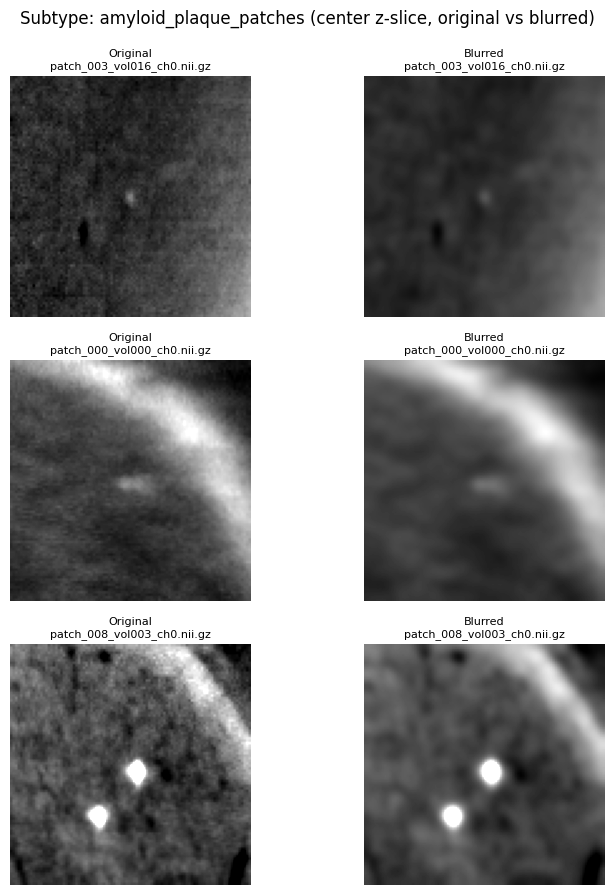

Subtype: c_fos_positive_patches | total patches: 4 | showing: 3


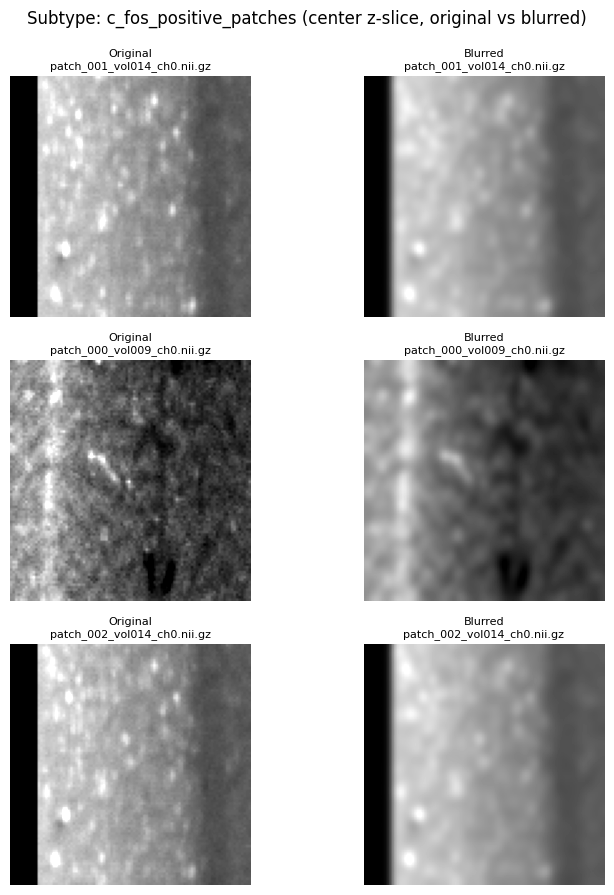

Subtype: cell_nucleus_patches | total patches: 25 | showing: 3


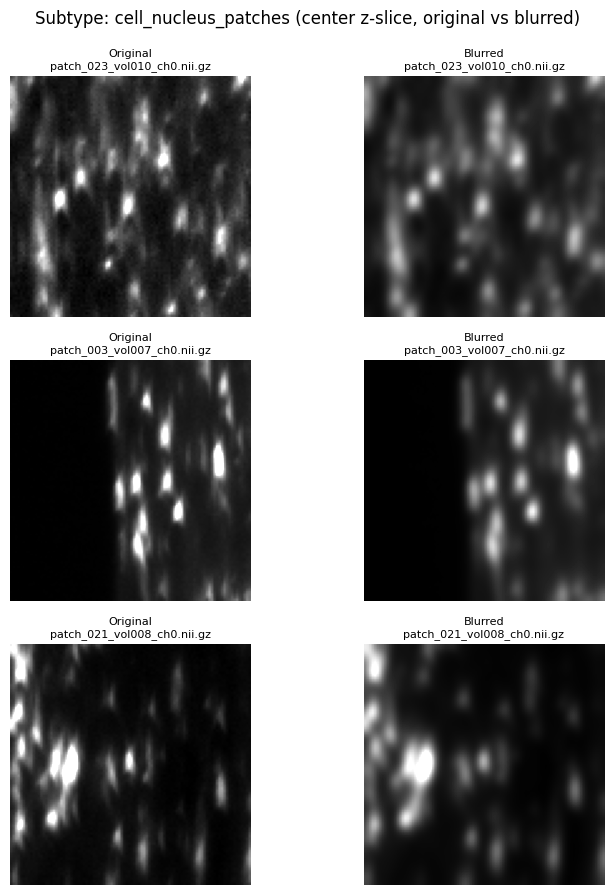

Subtype: vessels_patches | total patches: 40 | showing: 3


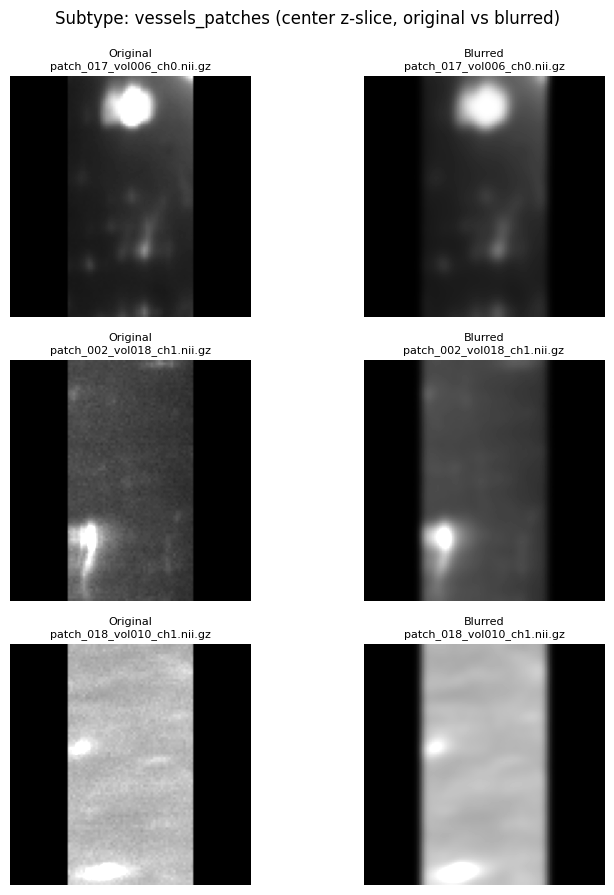

In [3]:
import random
from pathlib import Path

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---

ORIG_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")
BLUR_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches_blurred")

SUBTYPES = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

N_SAMPLES_PER_TYPE = 3  # how many random patches per subtype
RANDOM_SEED = 42

random.seed(RANDOM_SEED)


def is_patch_file(p: Path) -> bool:
    """Return True if this is a patch volume (not a label)."""
    if not p.is_file():
        return False
    name = p.name
    if "label" in name:
        return False
    return name.endswith(".nii") or name.endswith(".nii.gz")


def load_center_slice(nifti_path: Path):
    """
    Load a NIfTI volume and return its center slice along the first axis (z),
    plus the full volume (for min/max).
    """
    img = nib.load(str(nifti_path))
    data = img.get_fdata(dtype=np.float32)

    if data.ndim == 3:
        z_center = data.shape[0] // 2
        slice_2d = data[z_center, :, :]
    elif data.ndim == 4:
        # Simple heuristic: assume shape is (C, Z, Y, X) or (Z, Y, X, C)
        if data.shape[0] <= 4:  # (C, Z, Y, X) -> take first channel
            z_center = data.shape[1] // 2
            slice_2d = data[0, z_center, :, :]
        elif data.shape[-1] <= 4:  # (Z, Y, X, C) -> take first channel
            z_center = data.shape[0] // 2
            slice_2d = data[z_center, :, :, 0]
        else:
            # Fallback: treat like 3D
            z_center = data.shape[0] // 2
            slice_2d = data[z_center, :, :]
    else:
        raise ValueError(f"Unexpected data ndim={data.ndim} for {nifti_path}")

    return slice_2d, data


def visualize_pairs_for_subtype(subtype: str, n_samples: int = 3):
    orig_dir = ORIG_ROOT / subtype
    blur_dir = BLUR_ROOT / subtype

    all_patches = sorted([p for p in orig_dir.glob("*.nii*") if is_patch_file(p)])
    if not all_patches:
        print(f"No patch files found for subtype: {subtype}")
        return

    n_samples = min(n_samples, len(all_patches))
    sampled = random.sample(all_patches, n_samples)

    print(f"Subtype: {subtype} | total patches: {len(all_patches)} | showing: {n_samples}")

    fig, axes = plt.subplots(
        n_samples, 2, figsize=(8, 3 * n_samples),
        squeeze=False  # always 2D array of axes
    )

    for row_idx, orig_path in enumerate(sampled):
        # Derive blurred path from original path
        rel_path = orig_path.relative_to(ORIG_ROOT)
        blur_path = BLUR_ROOT / rel_path

        if not blur_path.exists():
            print(f"[WARN] Blurred file missing for {orig_path} -> {blur_path}, skipping.")
            continue

        orig_slice, orig_vol = load_center_slice(orig_path)
        blur_slice, blur_vol = load_center_slice(blur_path)

        # Use common vmin/vmax for fair visual comparison
        vmin = float(np.percentile(orig_vol, 1))
        vmax = float(np.percentile(orig_vol, 99))

        ax_orig = axes[row_idx, 0]
        ax_blur = axes[row_idx, 1]

        im0 = ax_orig.imshow(orig_slice, cmap="gray", vmin=vmin, vmax=vmax)
        ax_orig.set_title(f"Original\n{orig_path.name}", fontsize=8)
        ax_orig.axis("off")

        im1 = ax_blur.imshow(blur_slice, cmap="gray", vmin=vmin, vmax=vmax)
        ax_blur.set_title(f"Blurred\n{blur_path.name}", fontsize=8)
        ax_blur.axis("off")

    plt.suptitle(f"Subtype: {subtype} (center z-slice, original vs blurred)", y=0.99)
    plt.tight_layout()
    plt.show()


# --- Run visualization for each subtype ---

for subtype in SUBTYPES:
    visualize_pairs_for_subtype(subtype, n_samples=N_SAMPLES_PER_TYPE)
